In [123]:
from __future__ import print_function
import os
import glob
import random
from utils import mfccs_and_spec
import torch
from tqdm import tqdm
from IPython.display import Audio
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from librosa.feature.inverse import mel_to_audio
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle
from hparam import hparam as hp
from torch.functional import F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable, Function
import torch.optim as optim
from data_load import TripletSpeakerDataset
from speech_embedder_net import SpeechEmbedder, GE2ELoss, get_centroids, get_cossim

In [104]:
import librosa 
import librosa.display
import IPython
import pickle 
import numpy as np
import scipy 
import tensorflow as tf 
from tensorflow.python.client import device_lib
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.saved_model import simple_save

In [105]:
from utils import mfcc_for_accent
from data_preprocess import get_spectrogram_tisv

In [4]:
config = tf.ConfigProto(allow_soft_placement = True,
                        device_count = {'CPU' : 6,
                                       'GPU' : 0})

In [5]:
session = tf.Session(config=config)
K.set_session(session)

In [6]:
def make_accent_model():
    model = Sequential()

    model.add(Dense(50, input_shape = (14976,), activation = 'relu',name='input'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(75, activation = 'tanh', name='h1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh',name = 'h2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h4'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h5'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name ='h6'))
    model.add(BatchNormalization())

    model.add(Dense(3,  activation = 'softmax', name = 'output'))
    return model

In [56]:
##Mel spectrograms and MFCCs for Indians 
def get_accent_mfccs(path):
    x, _ = librosa.load(path)
    x, mf = mfcc_for_accent(x)
    mf = mf.flatten()
    #print(type(x))
    # l.append(librosa.feature.mfcc(x, sr=f))
    
    dat = np.reshape(mf, (1,mf.shape[0]))
    return mf, dat

In [8]:

embedder_net = SpeechEmbedder().to('cuda')
embedder_net.load_state_dict(torch.load(hp.model.model_path))
accent_net = make_accent_model()
accent_net.load_weights('accent_block_with_scottish.h5')
accent_net.pop()


#wav, sr = librosa.load(file_name)

def run_speaker_encoder(mfccs, embedder_net):
    mel_db = torch.transpose(mfccs, 1,2)
    #mel_db = torch.from_numpy(mel_db)
    #print(mel_db.shape)
    out = embedder_net(mel_db.to('cuda'))
    return out

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
from keras.utils import plot_model

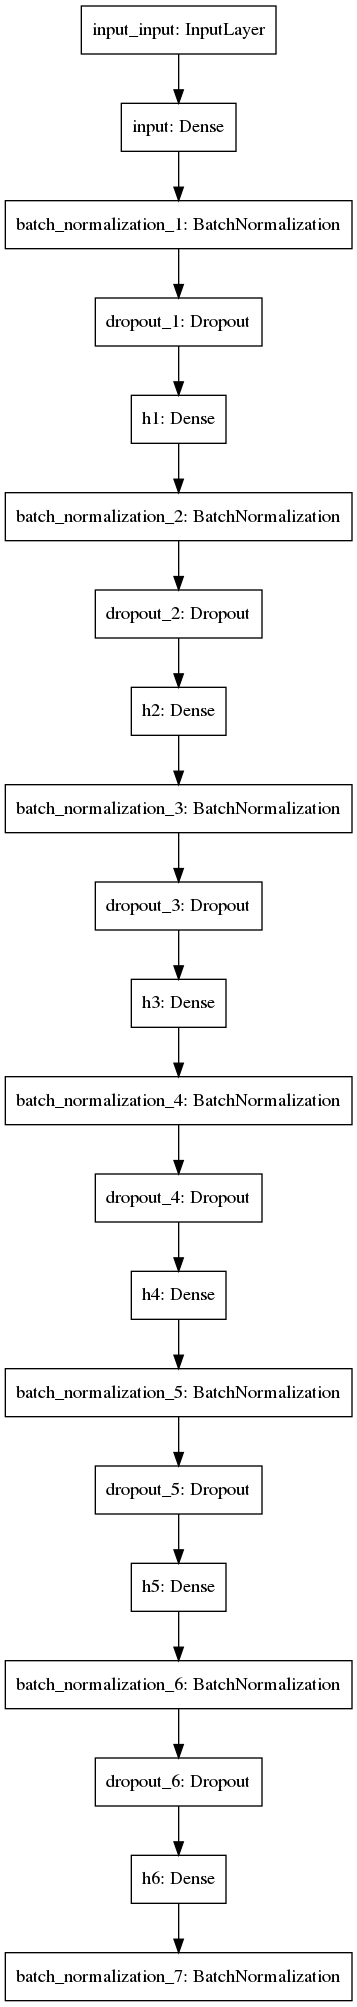

In [10]:
plot_model(accent_net, to_file='accent.png')

In [65]:
def get_both_embs(path):
        #for path in enumerate(train_dataset):
        _, accent_mfccs = get_accent_mfccs(path)
        speaker_mfccs = get_spectrogram_tisv(path)
        #print(accent_mfccs.shape)
        #print(speaker_mfccs.shape)
        speaker_mfccs = Variable(torch.from_numpy(speaker_mfccs)).to('cuda')
        speaker_emb = run_speaker_encoder(speaker_mfccs, embedder_net)
        #print(speaker_emb.shape)
        accent_emb = accent_net.predict(accent_mfccs)
        #print(accent_emb.shape)
        return speaker_emb.cpu().detach().numpy(), accent_emb

In [12]:
dataset = TripletSpeakerDataset()
data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)

In [14]:
class PairwiseDistance(Function):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        
        #print("above assert: ",x1, x2)
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

class TripletLoss(Function):
    """
    Triplet loss function.
    """
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(torch.from_numpy(anchor), positive)
        d_n = self.pdist.forward(torch.from_numpy(anchor), torch.from_numpy(negative))

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.inp1 = nn.Linear(in_features=256, out_features=100)
        self.inp2 = nn.Linear(in_features=100, out_features=100)
        self.b_n = nn.BatchNorm1d(128)
        
        self.drop_out = nn.Dropout(0.25)
        self.l1 = nn.Linear(200, 128)
        self.l2 = nn.Linear(128,128)
        self.out_acc = nn.Linear(128, 100)
        self.out_speak = nn.Linear(128,256)
        
    def forward(self, *args):
        speaker_emb, acc_emb = args[0], args[1]
        x1 = F.relu(self.inp1(speaker_emb))
        
        x2 = F.relu(self.inp2(x1))
        #print(x1.shape, x2.shape, speaker_emb.shape, acc_emb.shape)
        out = torch.cat((x1, x2), axis=1)
        out = self.l1(out)
        out = F.relu(out)
        out = F.relu(self.l2(out))
        
        mf_acc = self.out_acc(out)
        mf_sp = self.out_speak(out)
        return F.relu(mf_sp), F.relu(mf_acc)

In [17]:
def train():
    device = hp.device
    dataset = TripletSpeakerDataset()
    data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)
    ae = AutoEncoder().to('cuda')
    writer = SummaryWriter('triplet_loss_logs')
    optimizer = optim.Adam(ae.parameters())
    optimizer.zero_grad()
    #ae.load_state_dict(torch.load(''))
    trip_loss = TripletLoss()
    total_loss = 0
    for epoch in range(20):
        for batch_id, (anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent) in tqdm(enumerate(data_loader), total = len(data_loader)):
            anchor_utter_path, positive_utter_path, negative_utter_path = anchor_utter_path[0], positive_utter_path[0], negative_utter_path[0]
            accent_negative_path, speaker_positive_id, speaker_negative_id = accent_negative_path[0], speaker_positive_id[0], speaker_negative_id[0]
            speaker_anchor_id, positive_accent, negative_accent = speaker_anchor_id[0], positive_accent[0], negative_accent[0]
            
            try:
                pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(positive_utter_path)
                pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cuda'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cuda')
                anchor_utter_path
                anchor_speaker_embs, anchor_accent_embs = get_both_embs(anchor_utter_path)
                negative_speaker_embs, _ = get_both_embs(negative_utter_path)
                _, negative_accent_embs = get_both_embs(accent_negative_path)
            except ValueError:
                print("ValueError")
                continue
            except:
                continue
            positive_speaker_embs, positive_accent_embs = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
            positive_speaker_embs, positive_accent_embs = positive_speaker_embs.to('cpu'), positive_accent_embs.to('cpu')
            optimizer.zero_grad()
            #print(anchor_accent_embs.shape)
            accent_trip_loss = trip_loss.forward(anchor_accent_embs, positive_accent_embs, negative_accent_embs)
            speaker_trip_loss = trip_loss.forward(anchor_speaker_embs, positive_speaker_embs, negative_speaker_embs)
            criterion = accent_trip_loss + speaker_trip_loss
            total_loss += criterion
            
            criterion.backward()
            optimizer.step()
            writer.add_scalar('Loss', criterion, epoch*len(data_loader)+1)
            
            if (batch_id + 1) % 5 == 0:
                mesg = "{}\tEpoch:{},Iteration:{}\tLoss:{}\t\n".format(time.ctime(), epoch+1,
                        batch_id+1, criterion)
                print(mesg)
                if hp.train.log_file is not None:
                    with open(hp.train.log_file,'a') as f:
                        f.write(mesg)
            if hp.train.checkpoint_dir is not None and (batch_id + 1) % 100 == 0:
                ae.eval()
                ckpt_model_filename = "ckpt_epoch_" + str(batch_id+1) + "_batch_id_" + str(batch_id+1) + ".pth"
                ckpt_model_path = os.path.join("new_checkpoints/", ckpt_model_filename)
                torch.save(ae.state_dict(), ckpt_model_path)
                ae.to(device).train()
        ae.eval()
        save_model_filename = "final_epoch_" + str(epoch + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
        save_model_path = os.path.join(hp.train.checkpoint_dir, save_model_filename)
        torch.save(ae.state_dict(), save_model_path)

        print("\nDone, trained model saved at", save_model_path)

In [19]:
ae = AutoEncoder().to('cuda')

In [22]:
ae.load_state_dict(torch.load("./new_checkpoints/ckpt_epoch_5_batch_id_8000.pth")['state_dict'])

<All keys matched successfully>

In [71]:
def predict(file, ae):
    pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file)
    pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cuda'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cuda')
    print(pre_positive_speaker_embs.shape, pre_positive_accent_embs.shape)
    utt, acc = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
    return utt, acc

In [142]:
a11, a12 = predict("./data/Scottish/p284/p284_001_mic1.flac", ae)
a21, a22 = predict("./data/Scottish/p284/p284_001_mic2.flac", ae)
b11, b12 = predict("./data/Scottish/p249/p249_002_mic1.flac", ae)

torch.Size([1, 256]) torch.Size([1, 100])
torch.Size([1, 256]) torch.Size([1, 100])
torch.Size([1, 256]) torch.Size([1, 100])


In [61]:
loss = PairwiseDistance(2)

In [146]:
print(loss(a2, b1))

tensor([0.2318], device='cuda:0', grad_fn=<PairwiseDistance>)


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


In [145]:
print(loss(a11, a21))

tensor([0.0344], device='cuda:0', grad_fn=<PairwiseDistance>)


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


In [147]:
print(loss(b11, a21))

tensor([0.2318], device='cuda:0', grad_fn=<PairwiseDistance>)


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


In [88]:
a11 = torch.reshape(a11, (32, -1))

In [98]:
a11 = a11.cpu().detach().numpy()

In [99]:
a11

array([[0.09704909, 0.        , 0.        , 0.        , 0.08874042,
        0.13925603, 0.        , 0.04774197],
       [0.        , 0.        , 0.        , 0.06425845, 0.00712441,
        0.        , 0.07548737, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.04023223, 0.        , 0.052444  , 0.        ,
        0.        , 0.        , 0.        ],
       [0.08166239, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00903988],
       [0.03622869, 0.07396801, 0.        , 0.        , 0.        ,
        0.03870355, 0.        , 0.        ],
       [0.        , 0.        , 0.04617419, 0.        , 0.        ,
        0.13558912, 0.        , 0.        ],
       [0.04673819, 0.        , 0.        , 0.        , 0.08054979,
        0.        , 0.        , 0.        ],
       [0.        , 0.01432818, 0.        , 0.        , 0.        ,
        0.10474328, 0.      

In [100]:
mel_to_audio(a11)

array([-0.00469028, -0.00671686, -0.0054571 , ...,  0.00034307,
        0.00234611,  0.01051736], dtype=float32)

In [91]:
sp

array([[-2.9574418 , -3.1408577 , -3.2288108 , ..., -0.04820145,
        -0.13491176, -0.45288533],
       [-3.5211527 , -4.035727  , -4.043374  , ..., -0.58969617,
        -0.83069825, -0.95849276],
       [-4.7813525 , -5.162463  , -5.2870994 , ..., -1.5006808 ,
        -1.7813227 , -2.1918797 ],
       ...,
       [-5.994906  , -5.992143  , -5.9933677 , ..., -5.2240086 ,
        -5.6899986 , -5.6129103 ],
       [-5.993426  , -5.995006  , -5.994912  , ..., -4.7763224 ,
        -5.1335964 , -5.4855404 ],
       [-5.99448   , -5.9979343 , -5.9970665 , ..., -5.0080442 ,
        -5.285976  , -5.4001207 ]], dtype=float32)

In [82]:
mel_to_audio(sp)

array([-1.2838257e-10, -1.2812386e-10, -1.2786483e-10, ...,
       -1.0901711e-10, -1.0901914e-10, -1.0902092e-10], dtype=float32)

In [116]:
sp = get_spectrogram_tisv("./data/Scottish/p284/p284_001_mic2.flac")

In [117]:
sp = sp.squeeze()

In [118]:
sp.shape

(40, 180)

In [122]:
Audio(data = mel_to_audio(sp), rate = 22050)